## Imports

In [132]:
import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import category_encoders as ce
import plotly.graph_objs as go

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.pipeline import Pipeline

from xgboost import XGBRFClassifier, XGBRFRegressor, XGBClassifier

import eli5
from eli5.sklearn import PermutationImportance

from pdpbox.pdp import pdp_isolate, pdp_plot

from scipy.stats import boxcox
from scipy.special import inv_boxcox

import pprint
pp = pprint.PrettyPrinter(indent=4)

# Data Loading

In [91]:
odf = pd.read_csv('data/openpowerlifting.csv', low_memory=False)
odf.columns = [s.lower() for s in odf.columns.tolist()]
df = odf[keep].dropna()

# Data Processing

In [92]:
keep = [
 'sex',
 'age',
 'bodyweightkg',
 'best3squatkg',
 'best3benchkg',
 'best3deadliftkg',
 'totalkg'
 ]
convert = [
 'bodyweightkg',
 'best3squatkg',
 'best3benchkg',
 'best3deadliftkg',
 'totalkg'
 ]
converted = [
 'body_weight',
 'best_squat',
 'best_bench',
 'best_deadlift',
 'total'
 ]

# convert to lbs, absolute negative entries, to int, rename n drop old names
df[converted] = abs(df[convert]*2.2042).astype(int)
df = df.drop(convert, axis=1)

# adjust total given some entries were recorded as negatives
df['total']= df['best_squat']+df['best_bench']+df['best_deadlift']

# remove too old and too young and unrealistic totals
df = df[(df['age']>16)&(df['age']<60)&(df['total']>250)].drop_duplicates()

# add features of normalized lifts by total
to_normalize = ['best_squat','best_bench','best_deadlift']
for feature in to_normalize:
    df[feature+'_norm'] = df[feature]/df['total']

In [98]:
#remove normalized outliers to remove specfically recording errors
def remove_outliers(dataframe, feature, percent):
    condition = ((dataframe[feature] > dataframe[feature].quantile(percent))&
                (dataframe[feature] < dataframe[feature].quantile(1-percent)))
    return dataframe[condition]

men = df[df['sex']=='M']
women = df[df['sex']=='F']

for key, value in {'best_bench_norm':0.01,'best_squat_norm':0.01,'best_deadlift_norm':0.01}.items():
    men = remove_outliers(men, key, value)
    women = remove_outliers(women, key, value)

df = pd.concat([men, women])

# Men vs Women Lifting Graph

In [104]:
grapable_df = df.sample(10_000)
men = grapable_df[grapable_df['sex']=='M']
women = grapable_df[grapable_df['sex']=='F']

men_scatter = go.Scatter3d(x=men.best_squat, 
                     y=men.best_bench, 
                     z=men.best_deadlift,
                     mode='markers',
                     marker=dict(size=3,
                                line=dict(width=1),
                                color="blue"),
                     text=men.sex)
                     
women_scatter = go.Scatter3d(x=women.best_squat, 
                     y=women.best_bench, 
                     z=women.best_deadlift,
                     mode='markers',
                     marker=dict(size=3,
                                line=dict(width=1),
                                color="red"),
                     text=women.sex)

data_comp = [men_scatter, women_scatter]
fig = go.Figure(data_comp)
fig.show()

# Baseline

In [106]:
df.sex.value_counts(normalize=True)

M    0.71234
F    0.28766
Name: sex, dtype: float64

# Model Building

In [120]:
target = 'sex'
features = [ f for f in df.columns.tolist() if f !=target]
train, holdout, train_labels, holdout_labels = train_test_split(df[features],
                                                                df[target], 
                                                                test_size=0.10,
                                                                random_state=42,
                                                                stratify=df[target])

eval_set = [(train, train_labels), (holdout, holdout_labels)]

rfc = XGBClassifier(n_jobs=-1, n_estimators=1000, max_depth=5, random_state=42, objective = 'binary:logistic')

rfc.fit(train, train_labels.values.flatten(), eval_set=eval_set, eval_metric='logloss', early_stopping_rounds=50, verbose=0)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

# Validation Curve

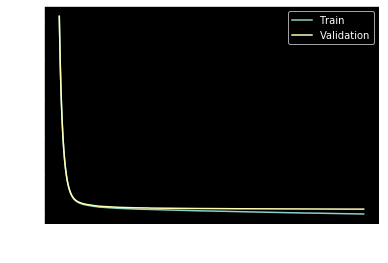

In [121]:
results = rfc.evals_result()
train_error = results['validation_0']['logloss']
val_error = results['validation_1']['logloss']
epoch = range(1, len(train_error)+1)

plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Validation')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.legend()
plt.show()

In [122]:
pred = rfc.predict(holdout)

# Confusion Matrix

In [123]:
labels = unique_labels(pred)
columns = [f'Predicted {label}' for label in labels]
index = [f'Actual {label}' for label in labels]
pd.DataFrame(confusion_matrix(pred, holdout_labels), columns=columns, index=index)

,Predicted F,Predicted M
Actual F,9373,673
Actual M,906,24781


# Permutation Importance

In [133]:
permuter = PermutationImportance(
    rfc, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(train, train_labels)

PermutationImportance(cv='prefit',
                      estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                              colsample_bylevel=1,
                                              colsample_bynode=1,
                                              colsample_bytree=1, gamma=0,
                                              learning_rate=0.1,
                                              max_delta_step=0, max_depth=5,
                                              min_child_weight=1, missing=None,
                                              n_estimators=1000, n_jobs=-1,
                                              nthread=None,
                                              objective='binary:logistic',
                                              random_state=42, reg_alpha=0,
                                              reg_lambda=1, scale_pos_weight=1,
                                              seed=None, silent=None,
                  

In [137]:
feature_names = train.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)

best_bench            0.119295
best_bench_norm       0.056308
best_deadlift         0.051867
best_deadlift_norm    0.026944
age                   0.025464
best_squat_norm       0.015149
body_weight           0.009292
total                 0.002837
best_squat            0.002285
dtype: float64

In [136]:
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names
)

Weight,Feature
0.1193 ± 0.0012,best_bench
0.0563 ± 0.0007,best_bench_norm
0.0519 ± 0.0010,best_deadlift
0.0269 ± 0.0006,best_deadlift_norm
0.0255 ± 0.0005,age
0.0151 ± 0.0002,best_squat_norm
0.0093 ± 0.0001,body_weight
0.0028 ± 0.0002,total
0.0023 ± 0.0002,best_squat


# PDP

In [128]:
isolated_bench_norm = pdp_isolate(
    model=rfc, 
    dataset=train, 
    model_features=train.columns,
    feature='best_bench_norm', 
    num_grid_points=50
)

isolated_total = pdp_isolate(
    model=rfc, 
    dataset=train, 
    model_features=train.columns,
    feature='total', 
    num_grid_points=50
)

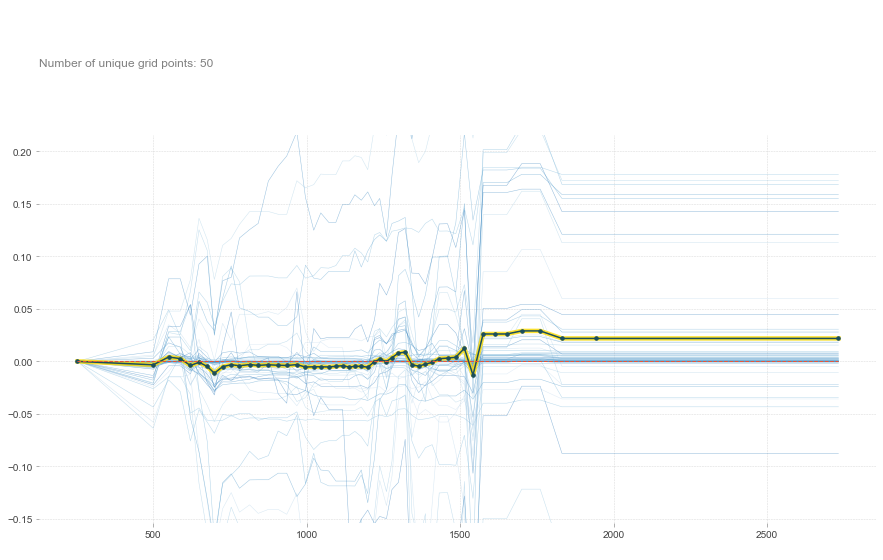

In [131]:
pdp_plot(isolated_total, feature_name='total', plot_lines=True, frac_to_plot=100)
plt.grid(color='grey')

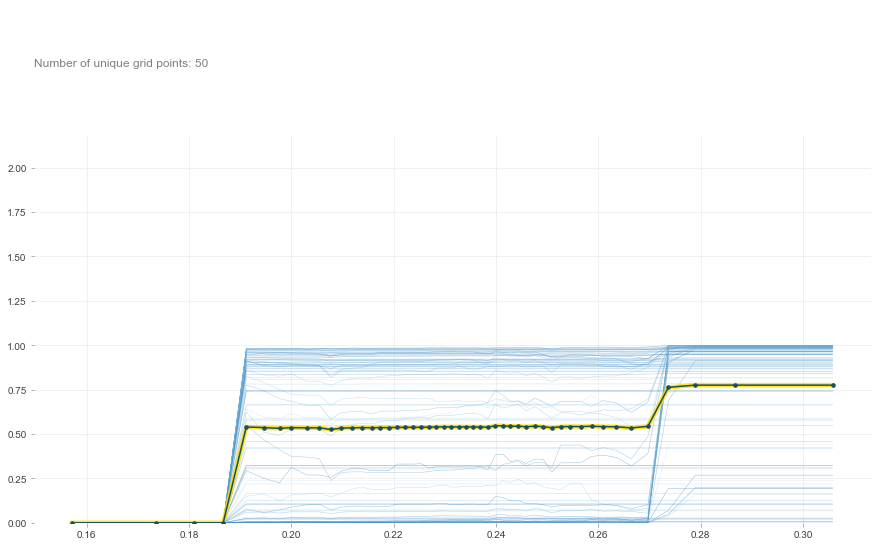

In [130]:
pdp_plot(isolated_bench_norm, feature_name=feature, plot_lines=True, frac_to_plot=100)
plt.grid(color='grey')